We establish that:
- a, h is established as being identical for all implementations
-  get agreement between Detailed (Original) and  Detailed (Debugged) by choosing the same associativity for the calculation of S

The agreement between Detailed (Debugged) and Fast remains elusive.

We consider a break case where:
- Msmt noise level is low
- Sigma == 0 => Q == 0
- R == 0 ==> S, W depend only on p_hat


Case 1: No Kalman state update. Propagate x_hat, p_hat according to a and h only. Checks that recursion is working correctly.
- Set output of calc_residuals ==0 
- Set "S" output of calc_Kalman_Gain ==0.

Results: 
- x_hat, P_hat identical in both filters
- The gain between Fast and Detailed KF still differs to the precision of 10^-18. However, it is not used in any calculations.

Case 2: Kalman update for P_hat only.
- Set output of calc_residuals ==0 
- Set "S" output of calc_Kalman_Gain as-is, such that it effects P_hat.

Results: 
- x_hat identical in both filters
- The gain between Fast and Detailed KF differs 
- P_hat inherits differences from gain


Case 3: Full Kalman update .
- Recreate error where green and blue data matches, red doesnt.

Case 4: Full Kalman update with S_inv==1 (artifically), S normal
- Set W=1.0, S = 1.0, S_inv = 1.0 for all time steps
- x_hat and p_hat are coupled, and want to confirm that all filters coincide for finite gain values. 

Results:

- For output of calc_residuals ==0 (e_z ==0)for all timesteps, there is perfect agreement between filters. 
- For e_z as is, filter diverges to large state estimate values (i.e. for n>5), but there is perfect agreement between red and blue filters. The modified calc_Kalman_gain code reads (exactly):

    S = 1.0 # Instead of: np.dot(np.dot(h,P_hat_apriori), h.T) + rk 
    
    S_inv = 1.0/S 
    
    W = np.ones_like(np.dot(P_hat_apriori,h.T))*S_inv
    
    
- To move from Case 4 to Case 3 means that we remove "S = 1.0" and "W = np.ones_like(...)" lines. Hence, for R==rk==0, the source of the divergence lies in the calc_Kalman_gain function for the following two lines:

    S = np.dot(np.dot(h,P_hat_apriori), h.T)
    
    S_inv = 1.0/S
    
    W = np.dot(P_hat_apriori,h.T))*S_inv
    
    
Since these are common to KF Fast and KF Detailed (Debugged), I conclude that numerical errors in these lines.

Case 5: As with Case 4, but we repeat in a manner to excerabate any errors relating to the representation of floating point numbers.
- Repeat such that S = 3.0/17.0 (This constant cannot be represented in base 2)
- Set W= 1.0 S_inv, S_inv = 1/S for all time steps
- Set output of calc_residuals ==0 (e_z ==0)for all timesteps to avoid large estimation values (overflow errors)
- x_hat and p_hat are coupled, and want to confirm that all filters coincide for finite gain values. 

Results: No difference to results as per Case 4. Red and Blue filters agree perfectly. There is no difference in gains or S_inv*WW^T


Case 6: Use A(BC) to do a consistent calculation of the Gain based on S using a new intermediary variable, as follows:

    intermediary = np.dot(P_hat_apriori, h.T)
    S = np.dot(h, intermediary) + rk
    S_inv = 1.0/S 
    
    if not np.isfinite(S_inv).all():
        print("S is not finite")
        raise RuntimeError
    
    W = intermediary*S_inv
    return W, S

In [1]:
import detailed_kf_bugtesting as bugdkf
import detailed_kf as dkf
import kf_fast as kffast
import matplotlib.pyplot as plt
from ML_Kalman import Kalman

In [2]:
figname = 'Full_KF_with_intermediary'
associativity = 'A(BC)' # A(BC) allows consistent calculation of the gain using "intermediary" variable.

In [3]:
import numpy as np

########################
# File Data
########################
filename0_ = 'buggy'
savetopath_ = './'

########################
# Bayes Risk Parameters
########################
max_it_BR_ = 2
num_randparams_ = 10
space_size_ = np.arange(-8,3)
truncation_ =20
bayes_params_ = [max_it_BR_, num_randparams_, space_size_,truncation_]

########################
# Experiment Parameters
########################
n_train_ = 2000
n_predict_ = 48
n_testbefore_ = 49
multiplier_ = 20.0 
bandwidth_ = 50.0

exp_params_ = [n_train_, n_predict_, n_testbefore_, multiplier_, bandwidth_]

########################
# Truth Parameters
########################
apriori_f_mean_ = 0.0 
alpha_ = 1.0
f0_ = 10.0
p_ = -1 #1 #-2 #-1 #0.0
J_ = 2
jstart_ = 1 # (not zero)
pdf_type_u_ = 'Uniform'
      
true_noise_params_ = [apriori_f_mean_, pdf_type_u_, alpha_, f0_, p_, J_, jstart_]

########################
# Measurement Noise 
########################
msmt_noise_mean_ = 0.0 
msmt_noise_level_ = 0.01 

msmt_noise_params_ = [msmt_noise_mean_, msmt_noise_level_]

########################
# Kalman Parameters
########################
p0_ = 10000.0 
x0_ = 1.0
optimal_sigma_ = 0.1
optimal_R_ = 0.1
b_delta_ = 0.5 

max_it_ = 5

kalman_params_ = [optimal_sigma_, optimal_R_, x0_, p0_, b_delta_]

########################
# Skip Msmts
########################
skip =1


Single Truth

In [4]:
from ML_Kalman import Kalman

Test_Object = Kalman(filename0_, savetopath_, max_it_,
                     exp_params_, kalman_params_, msmt_noise_params_,
                     true_noise_params_, user_defined_variance=None, 
                     skip_msmts=skip)

In [5]:
truth, signal = Test_Object.generate_data_from_truth(None)

Three different Kalman implementations - Fast, Detailed (Debugged), Detailed (Original)
We will feed same data to each implementation

In [6]:
pred_skf = kffast.kf_2017(signal, n_train_, n_testbefore_, n_predict_, Test_Object.Delta_T_Sampling, x0_, p0_, 
                          optimal_sigma_, optimal_R_, Test_Object.basisA, 
                          phase_correction=0 ,prediction_method="PropForward", skip_msmts=1, 
                          descriptor='Fast_KF')

pred_bugdkf, amps_bugdkf = bugdkf.detailed_kf("Debugging_KF", signal, 
                                              n_train_, n_testbefore_, n_predict_, Test_Object.Delta_T_Sampling, 
                                              x0_,p0_, optimal_sigma_, optimal_R_, Test_Object.basisA,
                                              0.0, skip_msmts=1)

pred_dkf, amps_dkf = dkf.detailed_kf("Detailed_KF", signal, 
                                              n_train_, n_testbefore_, n_predict_, Test_Object.Delta_T_Sampling, 
                                              x0_,p0_, optimal_sigma_, optimal_R_, Test_Object.basisA,
                                              0.0, skip_msmts=1)

Fast_KF
('Phase Correction = ', 0)
('Frequency Basis Array', array([  0. ,   0.5,   1. ,   1.5,   2. ,   2.5,   3. ,   3.5,   4. ,
         4.5,   5. ,   5.5,   6. ,   6.5,   7. ,   7.5,   8. ,   8.5,
         9. ,   9.5,  10. ,  10.5,  11. ,  11.5,  12. ,  12.5,  13. ,
        13.5,  14. ,  14.5,  15. ,  15.5,  16. ,  16.5,  17. ,  17.5,
        18. ,  18.5,  19. ,  19.5,  20. ,  20.5,  21. ,  21.5,  22. ,
        22.5,  23. ,  23.5,  24. ,  24.5,  25. ,  25.5,  26. ,  26.5,
        27. ,  27.5,  28. ,  28.5,  29. ,  29.5,  30. ,  30.5,  31. ,
        31.5,  32. ,  32.5,  33. ,  33.5,  34. ,  34.5,  35. ,  35.5,
        36. ,  36.5,  37. ,  37.5,  38. ,  38.5,  39. ,  39.5,  40. ,
        40.5,  41. ,  41.5,  42. ,  42.5,  43. ,  43.5,  44. ,  44.5,
        45. ,  45.5,  46. ,  46.5,  47. ,  47.5,  48. ,  48.5,  49. ,  49.5]))
1
Debugging_KF
('Phase Correction = ', 0.0)
('Frequency Basis Array', array([  0. ,   0.5,   1. ,   1.5,   2. ,   2.5,   3. ,   3.5,   4. ,
         4.5,   5. ,

Load data from Kalman implementations

In [7]:
bug_dkf_object = np.load('Debugging_KF.npz')
dkf_data_object = np.load('Detailed_KF.npz')
skf_data_object = np.load('Fast_KF.npz')

Compare the gain for Fast and Detailed (Debugged)

In [8]:
print np.alltrue(skf_data_object['store_S_Outer_W'][:,:,:]==bug_dkf_object['store_S_Outer_W'][:,:,:])

False


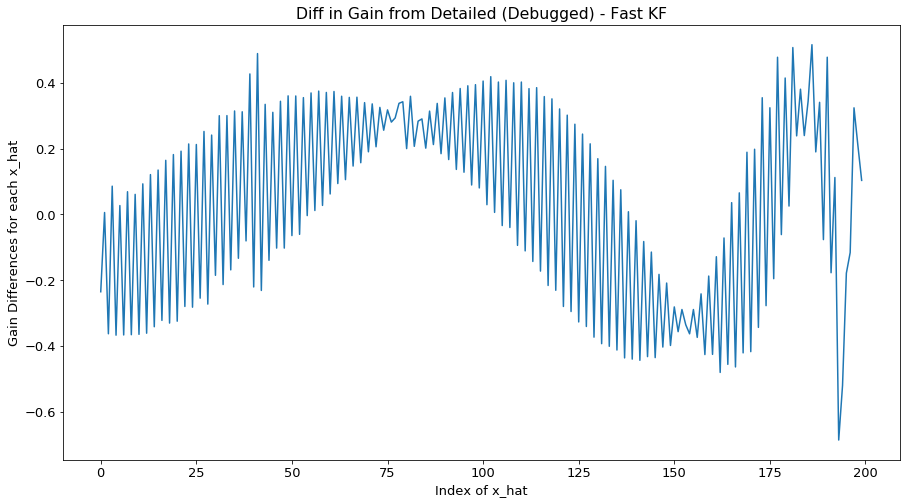

-5.28996609903
-4.58672230688


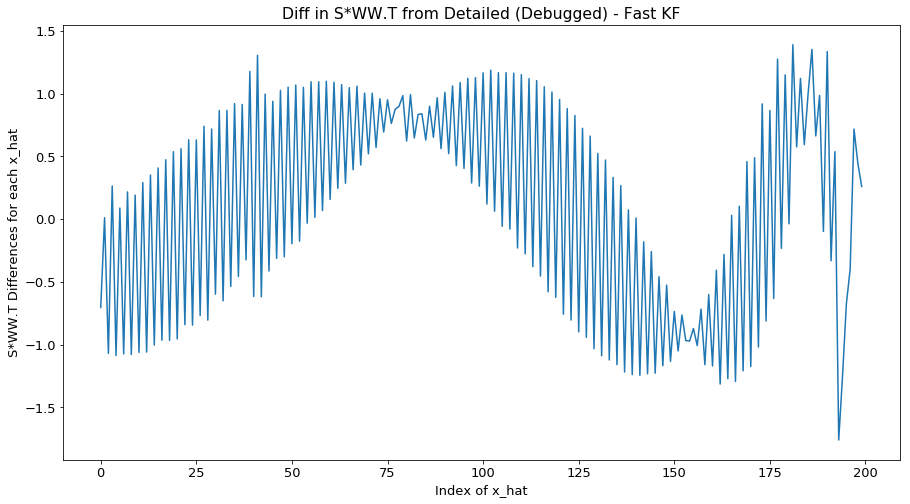

In [13]:
timestep=1000
plt.figure(figsize=(15,8))
gain_residuals = bug_dkf_object['W']-skf_data_object['W']
plt.ylabel('Gain Differences for each x_hat')
plt.xlabel('Index of x_hat')
plt.title('Diff in Gain from Detailed (Debugged) - Fast KF')
plt.plot(gain_residuals[:,0,timestep])
plt.savefig(figname+'_Differences_in_Gain_at_%s'%(timestep), format="svg")
plt.show()

item ='store_S_Outer_W' # 'x_hat'
print skf_data_object[item][0,0,timestep]
print bug_dkf_object[item][0,0,timestep]

plt.figure(figsize=(15,8))
plt.ylabel('S*WW.T Differences for each x_hat')
plt.xlabel('Index of x_hat')
plt.title('Diff in S*WW.T from Detailed (Debugged) - Fast KF')
plt.plot(range(200), skf_data_object[item][:,0,timestep]-bug_dkf_object[item][:,0,timestep])
plt.savefig(figname+'_Differences_in_S_OuterW_at_%s'%(timestep), format="svg")
plt.show()



Compare Instantaneous Amplitudes (depends on x_hat only)

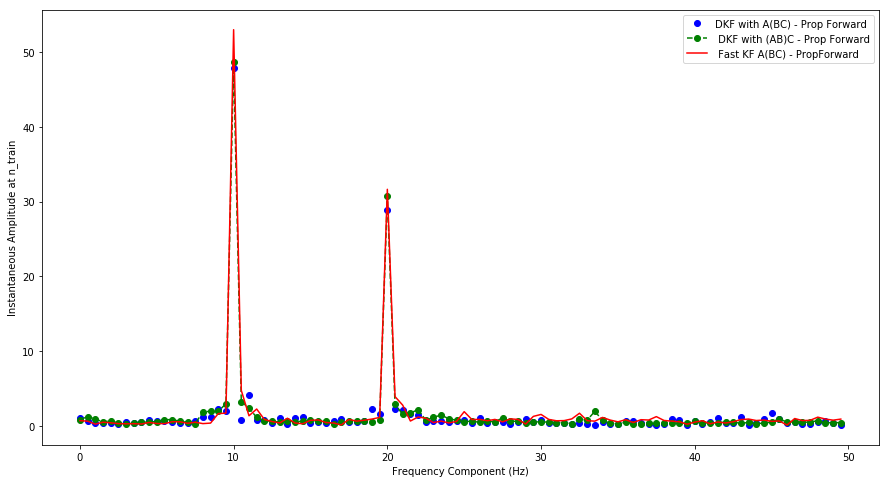

In [10]:
bug_dkf_object['instantA'][:, n_train_]

plt.figure(figsize=(15,8))

plt.xlabel('Frequency Component (Hz)')
plt.ylabel('Instantaneous Amplitude at n_train')

plt.plot(Test_Object.basisA, bug_dkf_object['instantA'][:, n_train_],'bo' , label='DKF with %s - Prop Forward'%(associativity))
plt.plot(Test_Object.basisA, dkf_data_object['instantA'][:, n_train_], 'go--', label=' DKF with (AB)C - Prop Forward')
plt.plot(Test_Object.basisA, skf_data_object['instantA'], 'r-', label=' Fast KF %s - PropForward'%(associativity))
plt.legend(loc=1)

plt.savefig(figname+'_Predictions', format="svg")
plt.show()

Compare predictions

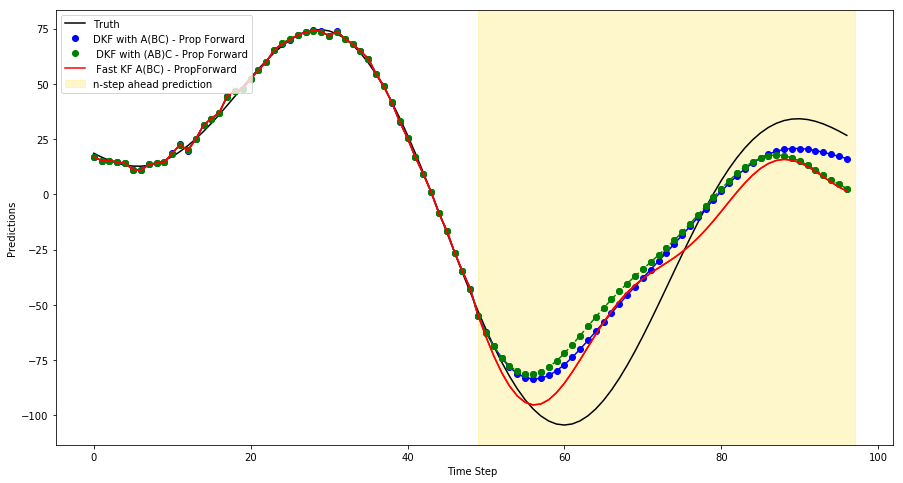

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))
i=0
item = 'x_hat'
plt.xlabel('Time Step ')
plt.ylabel('Predictions')

plt.plot(truth[n_train_ - n_testbefore_: n_train_ + n_predict_], 'k', label='Truth')

plt.plot(pred_bugdkf,'bo' , label='DKF with %s - Prop Forward'%(associativity))
plt.plot(pred_dkf, 'go', label=' DKF with (AB)C - Prop Forward')

plt.plot(bug_dkf_object['predictions'], 'b')
plt.plot(dkf_data_object['predictions'], 'go--')

plt.plot(pred_skf, 'r', label=' Fast KF %s - PropForward'%(associativity))
plt.plot(skf_data_object['predictions'], 'r')

plt.axvspan(n_testbefore_,n_testbefore_+n_predict_, ymin=0, ymax=1, color='gold', alpha=0.2, label='n-step ahead prediction ')
plt.legend(loc=2)

plt.savefig(figname+'_Predictions', format="svg")
plt.show()

Compare intermediate state estimation and Kalman gains

('Frequency = ', 0.0)


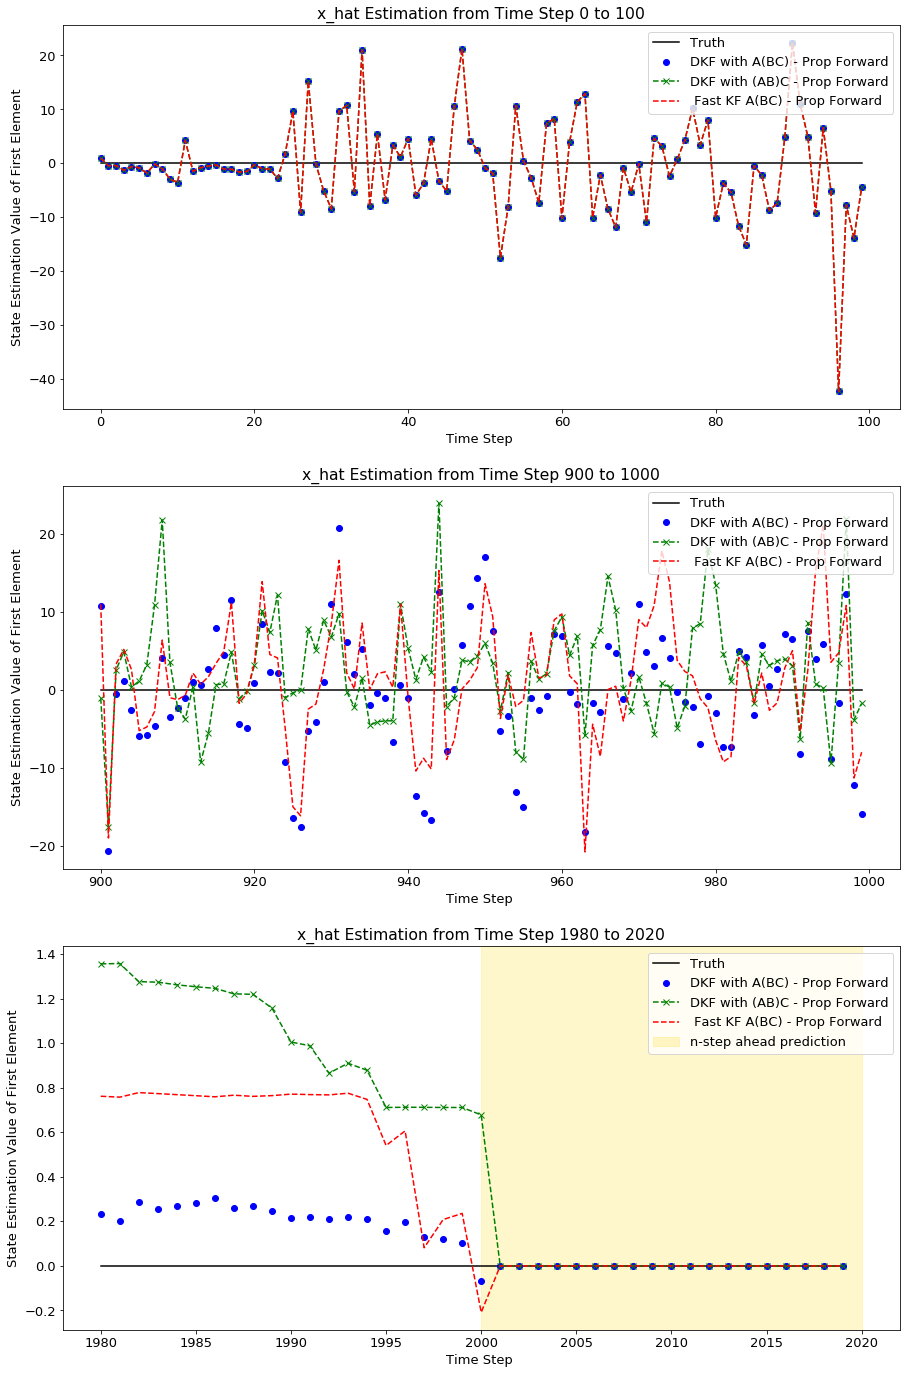

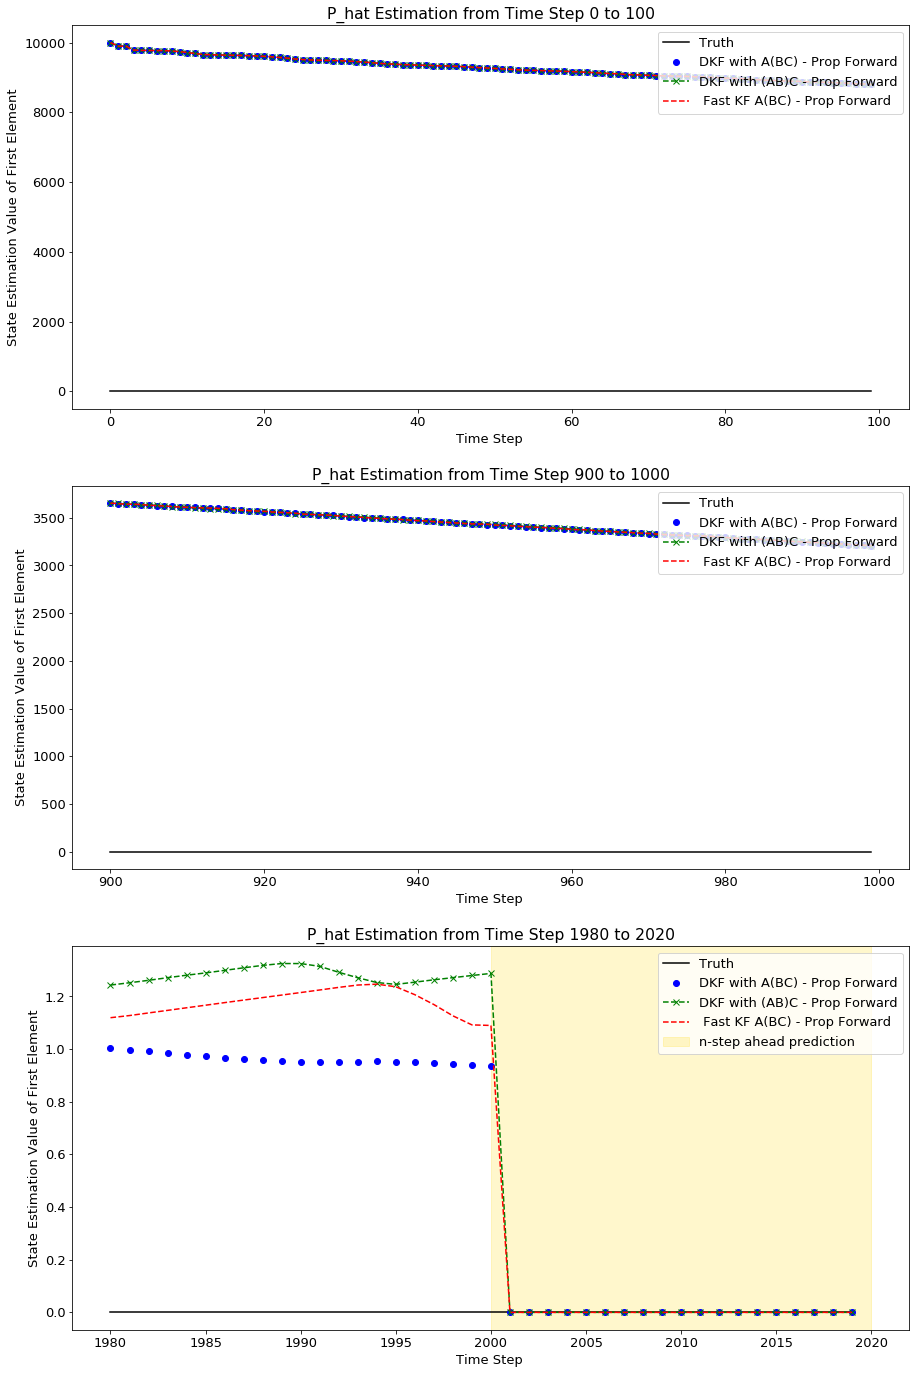

In [12]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.size']= 13

compnt = 0
print("Frequency = ",Test_Object.basisA[int(compnt/2.0)])
item_list = [ 'x_hat', 'P_hat' ]
time_start = [0, 900, 1980]
time_end =[100, 1000, 2020]
i=0
for idx_k in xrange(2):
    plt.figure(figsize=(15,24))
    for i in xrange(3):
        item = item_list[idx_k]
        plt.subplot(3,1,i+1)
        plt.title('%s Estimation from Time Step %s to %s' %(item, time_start[i], time_end[i]))
        plt.xlabel('Time Step ')
        plt.ylabel('State Estimation Value of First Element')
        plt.plot(range(time_start[i], time_end[i], 1), np.zeros(time_end[i] - time_start[i]), 'k', label='Truth')
        plt.plot(range(time_start[i], time_end[i], 1), bug_dkf_object[item][compnt,0,time_start[i]:time_end[i]],'bo' , label='DKF with %s - Prop Forward' %(associativity))
        plt.plot(range(time_start[i], time_end[i], 1), dkf_data_object[item][compnt,0,time_start[i]:time_end[i]], 'gx--' , label='DKF with (AB)C - Prop Forward')
        plt.plot(range(time_start[i], time_end[i], 1), skf_data_object[item][compnt,0,time_start[i]:time_end[i]], 'r--', label=' Fast KF %s - Prop Forward'%(associativity))
        if i==2:
            plt.axvspan(n_train_, time_end[i], ymin=0, ymax=1, color='gold', alpha=0.2, label='n-step ahead prediction ')
        plt.legend(loc=1)
    plt.savefig(figname+item, format="svg")
    plt.show()

The bug testing version of the DKF confirms that the following are not the causes for disparity (individually added and tested):
    - Calc_Gamma is not the cause of the disparity
    - Change "twonumf = numf*2" to "twonumf = int(numf*2)"
    - Convert n_converge to n_train in the entire code
    - Changing S_inv to 1.0/S
    - Changing from math.cos to np.cos
    - Optimising using numba
    
The following change has an impact:
    - Changing np.dot(np.dot()) instance to numpy.linalg.multi_dot()
    

figname+item

#### Create collated SVG figure
import svgutils.transform as sg
import sys 

'''
Filname for compiled image:  'compiled'
'''
#create new SVG figure
fig = sg.SVGFigure("15cm", "24cm")

figureimp = sg.fromfile(figname+item)
figimp = figureimp.getroot()
figimp.moveto(10,0,scale=0.49)
fig.append(figimp)
fig.save("compiled.svg")

# Export as pdf using Shell
!echo $SHELL
!pwd
!inkscape --export-pdf=FIG_Kalman_DKF_with_Different_Associativity_Predictions.pdf compiled.svg
!exit